## 1. Persiapan

Install library yang diperlukan (jika belum). Library `pytz` diperlukan untuk menghitung waktu zona (zone time), sedangkan `skyfield` digunakan untuk menghitung posisi benda langit dan waktu.

In [ ]:
!pip install pytz

In [ ]:
# !pip install scienceplots

In [ ]:
!pip install skyfield

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.2/336.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.3/232.3 kB 12.3 MB/s eta 0:00:00


## 2. Import Library
Import semua library yang diperlukan.

In [ ]:
from skyfield import api
from skyfield import almanac
from skyfield.nutationlib import iau2000b
from skyfield.units import Angle
from datetime import timedelta
import astropy.units as u
from datetime import datetime
from pytz import timezone

## 3. Definisikan semua parameter yang diperlukan
Buat time scale (untuk konversi tanggal dan waktu) dan unduh ephemeris. Ephemeris yang digunakan berasal dari JPL NASA versi `de441.bsp`

In [ ]:
timescale = api.load.timescale()
ephemeris = api.load('de441.bsp')

[#################################] 100% de441.bsp


In [ ]:
print(ephemeris)

SPICE kernel file 'de441.bsp' has 28 segments
  JD -3100015.50 - JD 2440432.50  (-13200-05-06 through 1969-07-29)
      2 -> 299  VENUS BARYCENTER -> VENUS
      1 -> 199  MERCURY BARYCENTER -> MERCURY
      3 -> 399  EARTH BARYCENTER -> EARTH
      3 -> 301  EARTH BARYCENTER -> MOON
      0 -> 10   SOLAR SYSTEM BARYCENTER -> SUN
      0 -> 9    SOLAR SYSTEM BARYCENTER -> PLUTO BARYCENTER
      0 -> 8    SOLAR SYSTEM BARYCENTER -> NEPTUNE BARYCENTER
      0 -> 7    SOLAR SYSTEM BARYCENTER -> URANUS BARYCENTER
      0 -> 6    SOLAR SYSTEM BARYCENTER -> SATURN BARYCENTER
      0 -> 5    SOLAR SYSTEM BARYCENTER -> JUPITER BARYCENTER
      0 -> 4    SOLAR SYSTEM BARYCENTER -> MARS BARYCENTER
      0 -> 3    SOLAR SYSTEM BARYCENTER -> EARTH BARYCENTER
      0 -> 2    SOLAR SYSTEM BARYCENTER -> VENUS BARYCENTER
      0 -> 1    SOLAR SYSTEM BARYCENTER -> MERCURY BARYCENTER
  JD 2440432.50 - JD 8000016.50  (1969-07-29 through 17191-03-14)
      2 -> 299  VENUS BARYCENTER -> VENUS
      1 -> 19

Definisikan posisi pengamat. Sesuaikan dengan lintang dan bujur pengamatan. Tanda (-) dan (+) untuk lintang berturut-turut adalah LS dan LU, sedangkan untuk bujur berturut-turut adalah BB dan BT.

In [ ]:
# Observatorium Bosscha 107:37:00 BT; -6:49:50 LS
longitude = 107 + 37/60
latitude = -(6 + 49/60 + 50/3600)

In [ ]:
bosscha_longlat = api.Topos(longitude=longitude, latitude=latitude)

Pilih rentang waktu yang ingin ditinjau. Pada contoh ini dipilih tanggal 2 - 3 September 2024.

In [ ]:
t1 = timescale.utc(2024, 9, 2, 0)
t2 = timescale.utc(2024, 9, 4, 0)

Cari waktu terbit dan terbenam Matahari dan Bulan dari posisi pengamat serta rentang waktu yang ditinjau.

In [ ]:
sunriset, sunBol = almanac.find_discrete(t1, t2, almanac.sunrise_sunset(ephemeris, bosscha_longlat))

In [ ]:
def moonrise_moonset(ephemeris, topos):
    moon = ephemeris['moon']
    topos_at = (ephemeris['earth'] + topos).at
    def is_moon_up_at(t):
        t._nutation_angles = iau2000b(t.tt)
        return topos_at(t).observe(moon).apparent().altaz()[0].degrees > -50/60
    is_moon_up_at.rough_period = 0.5
    return is_moon_up_at

In [ ]:
moonriset, moonBol = almanac.find_discrete(t1, t2, moonrise_moonset(ephemeris, bosscha_longlat))

In [ ]:
print(moonriset, moonBol)
print(sunriset, sunBol)

<Time tt=[2460555.9311865494 ... 2460557.4796302896] len=4> [0 1 0 1]
<Time tt=[2460555.9513282236 ... 2460557.451231344] len=4> [0 1 0 1]


Elemen 0 menunjukkan proses tenggelam, sedangkan 1 menunjukkan terbit.

In [ ]:
# print(moonBol)
# moonBol

## 4. Mencari Waktu Matahari terbenam

In [ ]:

# Urutkan nilai sunriset berdasarkan urutan nilai sunBol
# Ambil nilai elemen ke-0 dari sunriset
# sunset_time = sunriset[sunBol][0]
sunset_time = sunriset[sunBol == 0]



In [ ]:
# ubah ke waktu utc
print(sunset_time.utc_iso())

# ubah ke waktu lokal
wib = timezone('Asia/Jakarta')
print(sunset_time.astimezone(wib))



['2024-09-02T10:48:46Z', '2024-09-03T10:48:37Z']
[datetime.datetime(2024, 9, 2, 17, 48, 45, 574517, tzinfo=<DstTzInfo 'Asia/Jakarta' WIB+7:00:00 STD>)
 datetime.datetime(2024, 9, 3, 17, 48, 36, 580641, tzinfo=<DstTzInfo 'Asia/Jakarta' WIB+7:00:00 STD>)]


## 5. Mencari Waktu Bulan terbenam

In [ ]:
moonset_time = moonriset[moonBol == 0]

In [ ]:
# ubah ke waktu utc
print(moonset_time.utc_iso())

# ubah ke waktu lokal
print(moonset_time.astimezone(wib))

['2024-09-02T10:19:45Z', '2024-09-03T11:03:20Z']
[datetime.datetime(2024, 9, 2, 17, 19, 45, 333865, tzinfo=<DstTzInfo 'Asia/Jakarta' WIB+7:00:00 STD>)
 datetime.datetime(2024, 9, 3, 18, 3, 19, 746399, tzinfo=<DstTzInfo 'Asia/Jakarta' WIB+7:00:00 STD>)]


## 6. Mencari Waktu Konjungsi Terdekat

In [ ]:
# bre = timescale.utc(2024, 9, 2, 0)
t0 = timescale.utc(2024, 8, 27, 0) - timedelta(days = 10)
t1 = timescale.utc(2024, 8, 27, 0) + timedelta(days = 10)
phases_time, y = almanac.find_discrete(t0, t1, almanac.moon_phases(ephemeris))

In [ ]:
print(phases_time, y)
print([almanac.MOON_PHASES[yi] for yi in y])

<Time tt=[2460542.2687269 2460548.89375809 2460556.58107118]> [2 3 0]
['Full Moon', 'Last Quarter', 'New Moon']


In [ ]:
print(phases_time[y == 0].utc_iso())
print(phases_time[y == 0].astimezone(wib))

for time in phases_time[y == 0].astimezone(wib):
    print(time.strftime('%Y-%m-%d %H:%M:%S.%f %Z'))


['2024-09-03T01:55:35Z']
[datetime.datetime(2024, 9, 3, 8, 55, 35, 365937, tzinfo=<DstTzInfo 'Asia/Jakarta' WIB+7:00:00 STD>)]
2024-09-03 08:55:35.365937 WIB


## 7. Posisi Matahari dan Bulan saat Matahari Terbenam

In [ ]:
earth = ephemeris['Earth']
sun = ephemeris['Sun']
moon = ephemeris['Moon']

In [ ]:
bosscha = earth + bosscha_longlat

In [ ]:
# print(sunriset[sunBol][0])
print(sunset_time)
print(sunset_time[1])

<Time tt=[2460555.95132822 2460556.95122413]>
<Time tt=2460556.951224128>


In [ ]:
# Ingat! Saat Matahari Terbenam
sunradec = bosscha.at(sunset_time[1]).observe(sun).apparent()
moonradec = bosscha.at(sunset_time[1]).observe(moon).apparent()

print(sunradec.radec(epoch='date'))
print(moonradec.radec(epoch='date'))

(<Angle 10h 51m 27.66s>, <Angle +07deg 16' 42.2">, <Distance 1.00867 au>)
(<Angle 11h 05m 54.46s>, <Angle +07deg 35' 06.9">, <Distance 0.00270153 au>)


## 8. Ubah koordinat dalam Altitud dan Azimut jika diperlukan

In [ ]:
print(sunradec.altaz())
print(moonradec.altaz())

(<Angle -00deg 49' 59.9">, <Angle 277deg 13' 51.1">, <Distance 1.00867 au>)
(<Angle 02deg 41' 01.5">, <Angle 277deg 58' 22.7">, <Distance 0.00270153 au>)


## 9. Cari sudut Elongasi

In [ ]:
# elongasi toposentrik
sunradec.separation_from(moonradec)

<Angle 03deg 35' 40.0">

In [ ]:
# Posisi Bumi, Bulan, Matahari dari Barycentric
earth_pos = earth.at(sunset_time[1])
moon_pos  = earth_pos.observe(moon)
sun_pos   = earth_pos.observe(sun)

In [ ]:
# Posisi Matahari dan Bulan dalam barycentric (RA DEC)
sun_geocentric = sun_pos.apparent()
moon_geocentric= moon_pos.apparent()

In [ ]:
print('Elongasi Toposentrik: ', sunradec.separation_from(moonradec))
# print(sunradec.separation_from(moonradec))
print('Elongasi Geosentrik: ', sun_geocentric.separation_from(moon_geocentric))
# print(sun_geocentric.separation_from(moon_geocentric))

Elongasi Toposentrik:  03deg 35' 40.0"
Elongasi Geosentrik:  04deg 28' 44.5"


## 10. Hitung fraksi iluminasi

In [ ]:
illumination = 100.0 * moonradec.fraction_illuminated(sun)

print('Fraksi iluminasi: {:.4f} %'.format(illumination))

Fraksi iluminasi: 0.0986 %


## 11. Hitung usia sejak konjungsi sampai Matahari terbenam

In [ ]:
conjuction_time = phases_time[y == 0]
moon_age = (sunset_time[1] - conjuction_time) * 24. # convert fraction of day into hours

print('Usia Bulan saat Matahari terbenam: {:.4f} jam'.format(moon_age[0]))

Usia Bulan saat Matahari terbenam: 8.8837 jam


## 12. Buat ilustrasi konfigurasi Bulan-Matahari

In [ ]:
sunal, sunaz, sundist = sunradec.altaz()
moonal, moonaz, moondist = moonradec.altaz()

elongation = sun_geocentric.separation_from(moon_geocentric).degrees
elongation_topo = sunradec.separation_from(moonradec).degrees

relal = moonal.degrees - sunal.degrees
relaz = moonaz.degrees - sunaz.degrees


sunset_time_in_localtime = sunset_time[1].astimezone(wib).strftime('%Y-%m-%d %H:%M:%S.%f %Z')

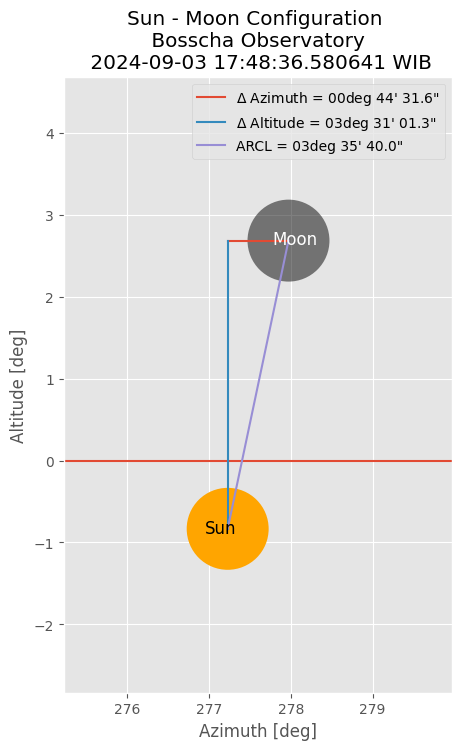

In [ ]:
import astropy.units as u
import matplotlib.pyplot as plt

plt.style.use(['ggplot'])

lingkaranMatahari = plt.Circle((sunaz.degrees, sunal.degrees),
                        (0.5*u.deg).value,
                        fc='orange')
lingkaranBulan = plt.Circle((moonaz.degrees, moonal.degrees),
                          (0.5*u.deg).value,
                          fc='black', alpha=.5)

plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect=1)
ax.add_patch(lingkaranMatahari)
ax.add_patch(lingkaranBulan)
if sunaz.degrees <= moonaz.degrees:
    xlimlow = sunaz.degrees
    xlimhigh = moonaz.degrees
else:
    xlimlow = moonaz.degrees
    xlimhigh = sunaz.degrees
if sunal.degrees <= moonal.degrees:
    ylimlow = sunal.degrees
    ylimhigh = moonal.degrees
else:
    ylimlow = moonal.degrees
    ylimhigh = sunal.degrees
plt.xlim(xlimlow-2, xlimhigh+2)
plt.ylim(ylimlow-2, ylimhigh+2)
plt.text(sunaz.degrees-0.28, sunal.degrees-0.05, 'Sun', fontsize=12)
plt.text(moonaz.degrees-0.2, moonal.degrees-0.05, 'Moon', fontsize=12, color='white')

plt.axhline(y=0)
plt.plot([moonaz.degrees, sunaz.degrees],
          [moonal.degrees, moonal.degrees],
          label='$\Delta$ Azimuth = {}'.format(Angle(degrees=relaz).dstr()))
plt.plot([sunaz.degrees, sunaz.degrees],
          [moonal.degrees, sunal.degrees],
          label='$\Delta$ Altitude = {}'.format(Angle(degrees=relal).dstr()))
plt.plot([moonaz.degrees, sunaz.degrees],
          [moonal.degrees, sunal.degrees],
          label='ARCL = {}'.format(Angle(degrees=elongation_topo).dstr()))
plt.xlabel('Azimuth [deg]')
plt.ylabel('Altitude [deg]')
plt.legend()
plt.title(f'Sun - Moon Configuration \n Bosscha Observatory \n {sunset_time_in_localtime}')
plt.show()

## 13. Plot ketinggian dan elongasi untuk grid posisi di Indonesia

Untuk studi kasus, diambil tanggal 3 September 2024.

In [ ]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 66.6 MB/s eta 0:00:00


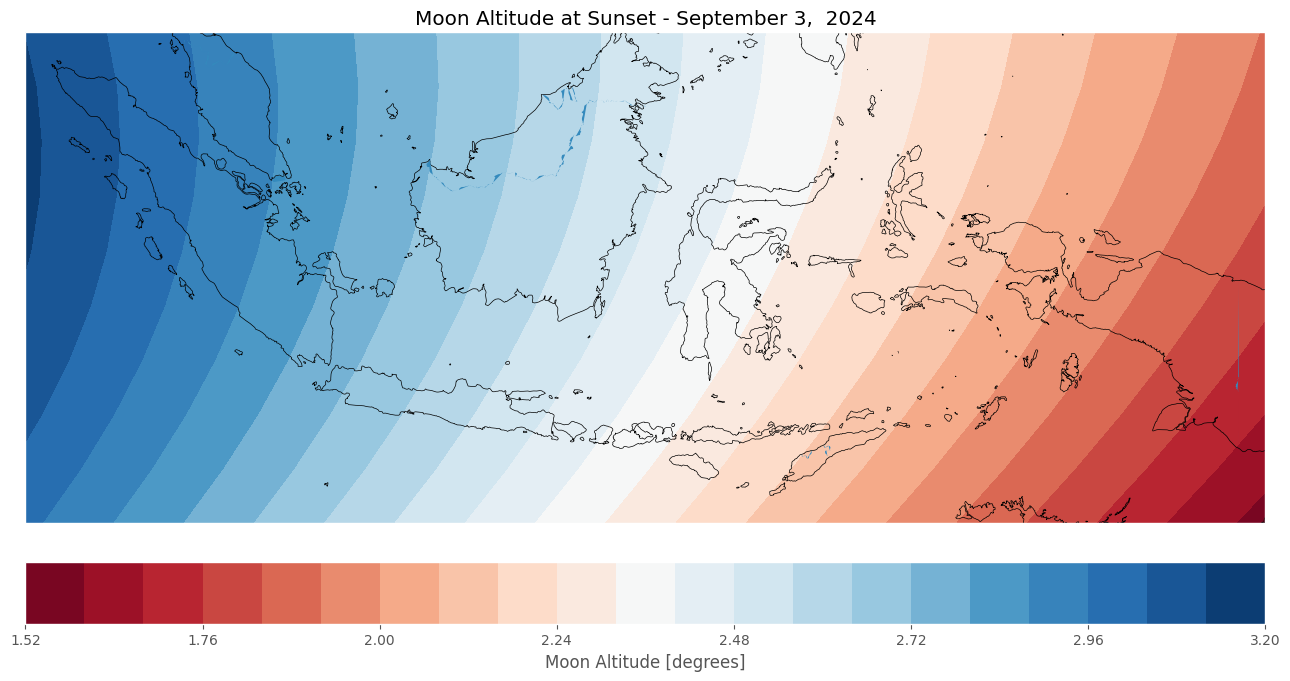

In [ ]:
# from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import matplotlib.pyplot as plt
from skyfield.api import load, Topos
from skyfield.almanac import find_discrete, sunrise_sunset
from pytz import timezone
from cartopy import crs as ccrs
from cartopy.feature import NaturalEarthFeature

# Load ephemeris data
eph = load('de441.bsp')  # Or use 'de441.bsp'
sun, moon = eph['sun'], eph['moon']

# Set date range and observer latitude/longitude range
ts = load.timescale()
dates = ts.utc(2024, 9, 3, 0)  # Example: September 2024
latitudes = np.linspace(-12, 7, 10)  # Indonesia's latitude range
longitudes = np.linspace(94, 142, 10)  # Indonesia's longitude range

# Initialize arrays to store results
altitudes = np.zeros((len(latitudes), len(longitudes)))
elongations = np.zeros((len(latitudes), len(longitudes)))
julian_dates = np.zeros((len(latitudes), len(longitudes)))  # Array to store Julian dates

# Define time zones based on longitude
def determine_time_zone(lon):
    if lon < 112.5:
        return timezone('Asia/Jakarta')  # WIB (UTC+7)
    elif 112.5 <= lon < 127.5:
        return timezone('Asia/Makassar')  # WITA (UTC+8)
    else:
        return timezone('Asia/Jayapura')  # WIT (UTC+9)

t0 = dates
t1 = dates + 1

# Iterate over locations
for i, lat in enumerate(latitudes):
    for j, lon in enumerate(longitudes):
        observer = Topos(latitude_degrees=lat, longitude_degrees=lon)
        observer_at = eph['earth'] + observer
        observer_at_geocenter = eph['earth']

        # Find sunset time in UTC
        # t0, t1 = dates
        f = sunrise_sunset(eph, observer)
        sunset_times, is_sunsets = find_discrete(t0, t1, f)
        sunset_times = sunset_times[is_sunsets == False]  # Keep only sunset times

        # Determine local time zone and adjust sunset times
        local_tz = determine_time_zone(lon)
        local_sunset_times = [t.utc_datetime().replace(tzinfo=timezone('UTC')).astimezone(local_tz) for t in sunset_times]

        # Compute Moon's altitude, azimuth, elongation, and Julian date at local sunset times
        for local_sunset_time in local_sunset_times:
            # Ensure the local_sunset_time is timezone-aware and convert it back to UTC
            local_sunset_time_utc = local_sunset_time.astimezone(timezone('UTC'))

            # Convert to a Skyfield Time object
            skyfield_time = ts.from_datetime(local_sunset_time_utc)
            # julian_date = skyfield_time.utc_jd()

            astrometric = observer_at.at(skyfield_time).observe(moon)
            astrometric_geocentric = observer_at_geocenter.at(skyfield_time).observe(moon)

            apparent = astrometric.apparent()
            apparent_geocentric = astrometric_geocentric.apparent()

            alt, az, _ = apparent.altaz()

            astrometric_sun = observer_at.at(skyfield_time).observe(sun)
            astrometric_sun_geocentric = observer_at_geocenter.at(skyfield_time).observe(sun)

            # elongation = astrometric.separation_from(astrometric_sun).degrees
            elongation = astrometric_geocentric.separation_from(astrometric_sun_geocentric).degrees
            altitudes[i, j] = alt.degrees
            elongations[i, j] = elongation
            # julian_dates[i, j] = julian_date

# Plotting
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([94, 142, -12, 7], crs=ccrs.PlateCarree())

# Add coastlines and borders
ax.coastlines('10m')
ax.add_feature(NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '10m'))

# Contour plot for altitudes and elongations
contour_alt = ax.contourf(longitudes, latitudes, altitudes, levels=20, cmap='RdBu', transform=ccrs.PlateCarree())
# contour_elong = ax.contour(longitudes, latitudes, elongations, levels=20, cmap='plasma', transform=ccrs.PlateCarree())

# Add colorbars
cbar_alt = plt.colorbar(contour_alt, ax=ax, orientation='horizontal', pad=0.05, label='Moon Altitude [degrees]')
# cbar_alt = plt.colorbar(contour_alt, ax=ax, orientation='vertical', label='Moon Altitude (degrees)')
# cbar_elong = plt.colorbar(contour_elong, ax=ax, orientation='horizontal', label='Moon Elongation (degrees)')

plt.title('Moon Altitude at Sunset - September 3,  2024')
plt.show()


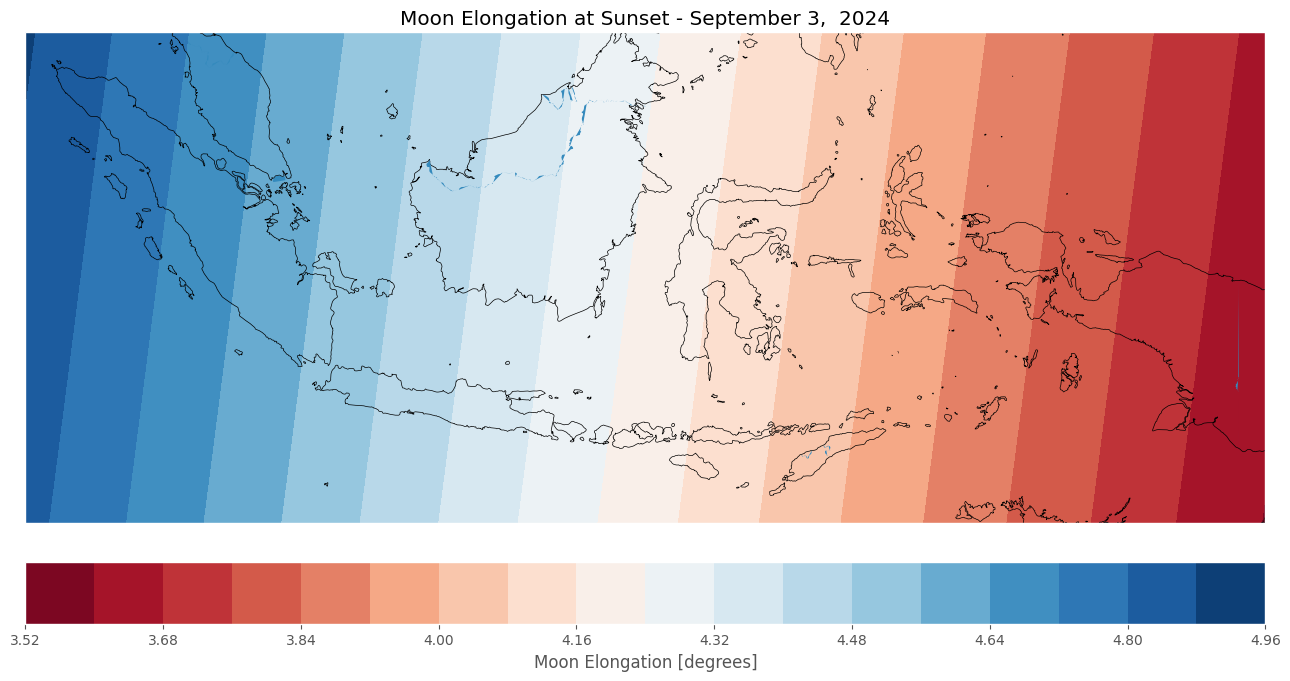

In [ ]:
# Plotting
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([94, 142, -12, 7], crs=ccrs.PlateCarree())

# Add coastlines and borders
ax.coastlines('10m')
ax.add_feature(NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '10m'))

# Contour plot for altitudes and elongations
contour_elong = ax.contourf(longitudes, latitudes, elongations, levels=20, cmap='RdBu', transform=ccrs.PlateCarree())

# Add colorbars
cbar_elong = plt.colorbar(contour_elong, ax=ax, orientation='horizontal', pad=0.05, label='Moon Elongation [degrees]')

plt.title('Moon Elongation at Sunset - September 3,  2024')
plt.show()
